In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBRanker
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
sns.set()
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from adapt.instance_based import KLIEP
from sklearn.feature_selection import SequentialFeatureSelector

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import CCA
from sklearn.cross_decomposition import PLSCanonical
from sklearn.cross_decomposition import PLSSVD
from operator import itemgetter
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

def my_custom_loss_func_exp(y_true, y_pred):
    return spearmanr(np.exp(y_true), np.exp(y_pred)).correlation  

def my_custom_loss_func(y_true, y_pred):
    #y_pred = np.exp(np.array(y_pred))
    return spearmanr(y_true, y_pred).correlation

def loss(y_true,y_pred):
    return np.corrcoef(y_true,y_pred)[0][1]

def select_columns(X, y, test_size = 0.33, size_features= 30, state = 100):
    dic = dict({})
    for i in range(100,100+state):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        all_corr = []
        for i in range(X_train.shape[1]):
            cor = my_custom_loss_func(y_train,X_train[:,i])
            all_corr.append(cor)
            
        all_corr = np.array(all_corr)
        cols = np.argsort(all_corr)[::-1]
        cols_keep = cols[:size_features]
        for i in cols_keep:
            if(i in dic):
                dic[i]+=1
            else:
                dic[i] = 1
   
    s = sorted(dic.items(), key=itemgetter(1),reverse=1)
    print(s)
    cols_keep = []
    for i in range(size_features):
        cols_keep.append(s[i][0])
    return np.array(cols_keep)

def evaluate_model_mean(X, y, model, stratify ,  test_size=0.33, loss = my_custom_loss_func, state = 100, size_features = 30):
    
    score = []
    for i in range(state):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=i, stratify=stratify)
        
        '''
        mask = (X_test['COUNTRY']==-1)
        X_test_FR = X_test[mask].copy()
        y_train = np.array(y_train)
        y_test_FR = np.array(y_test)[np.array(mask)].copy()
        
        
        mask = (X_test['COUNTRY']==1)
        X_test_DE = X_test[mask].copy()
        y_test_DE = np.array(y_test)[np.array(mask)].copy()
        '''
    
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        '''
        X_test_FR = np.array(X_test_FR)
        X_test_DE = np.array(X_test_DE)
        '''
        #model_pca = PCA(n_components=X_train.shape[1])
        #model_pca.fit(X_train)
        #X_train = model_pca.transform(X_train)
        #X_test = model_pca.transform(X_test)
                
        
        model.fit(X_train,y_train)
        train_score = loss(y_train, model.predict(X_train))
        y_predict = model.predict(X_test)
        test_score = loss(y_test , y_predict.reshape(-1))
        '''
        y_predict_FR = model.predict(X_test_FR)
        test_score_FR = loss(np.array(y_test_FR) , y_predict_FR.reshape(-1))
        
        y_predict_DE = model.predict(X_test_DE)
        test_score_DE = loss(np.array(y_test_DE) , y_predict_DE.reshape(-1))
        '''
        score.append([test_score])#,test_score_FR,test_score_DE])
        
    return np.mean(np.array(score),axis=0)


def evaluate_model_mean_lgb(X, y, model, stratify ,  test_size=0.33, loss = my_custom_loss_func, state = 100, size_features = 30):

    score = []
    for i in range(state):
        import lightgbm as lgbm

        X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y, test_size=0.3,random_state=i, stratify=stratify)
        X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train_m, y_train_m, test_size=0.2,random_state=i)

        lgbm_parameters ={
        'n_estimators': 10000,
        'learning_rate': 0.0941884136011224,
        'num_leaves': 180,
        'max_depth': 12,
        'min_data_in_leaf': 200,
        'lambda_l1': 0.01,
        'lambda_l2': 1,
        'min_gain_to_split': 8.756413243587552,
        'bagging_fraction': 0.6000000000000001,
        'bagging_freq': 1,
        'feature_fraction': 0.5}

        model = lgbm.LGBMRegressor(objective="regression", **lgbm_parameters)
        model.fit(
            X_train_m,
            y_train_m,
            eval_set=[(X_val_m,y_val_m)],
            eval_metric="l1",
            early_stopping_rounds=100
        )

        X_train_m = np.array(X_train_m)
        X_test_m = np.array(X_test_m)
        
        train_score = loss(y_train_m, model.predict(X_train_m))
        y_predict = model.predict(X_test_m)
        test_score = loss(y_test_m , y_predict.reshape(-1))
        
        score.append([test_score])
        
    return np.mean(np.array(score),axis=0)


def evaluate_model_mean_all(X, y, model, stratify ,  test_size=0.33, loss = my_custom_loss_func, state = 100, size_features = 30):
    
    score = []
    for i in range(state):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=i, stratify=stratify)
        
        
        mask = (X_test['COUNTRY']==-1)
        X_test_FR = X_test[mask].copy()
        y_train = np.array(y_train)
        y_test_FR = np.array(y_test)[np.array(mask)].copy()
        
        
        mask = (X_test['COUNTRY']==1)
        X_test_DE = X_test[mask].copy()
        y_test_DE = np.array(y_test)[np.array(mask)].copy()
      
    
        X_train = np.array(X_train)
        X_test = np.array(X_test)
      
        X_test_FR = np.array(X_test_FR)
        X_test_DE = np.array(X_test_DE)
      
        #model_pca = PCA(n_components=X_train.shape[1])
        #model_pca.fit(X_train)
        #X_train = model_pca.transform(X_train)
        #X_test = model_pca.transform(X_test)
                
        
        model.fit(X_train,y_train)
        train_score = loss(y_train, model.predict(X_train))
        y_predict = model.predict(X_test)
        test_score = loss(y_test , y_predict.reshape(-1))
        
        y_predict_FR = model.predict(X_test_FR)
        test_score_FR = loss(np.array(y_test_FR) , y_predict_FR.reshape(-1))
        
        y_predict_DE = model.predict(X_test_DE)
        test_score_DE = loss(np.array(y_test_DE) , y_predict_DE.reshape(-1))
      
        score.append([test_score,test_score_FR,test_score_DE])
        
    return np.mean(np.array(score),axis=0)

In [3]:
path = 'data/'
X_train = pd.read_csv( path + 'X_train.csv')
Y_train = pd.read_csv(path + 'Y_train.csv')
X_test = pd.read_csv(path + 'X_test.csv')

In [4]:
data = pd.merge(X_train, Y_train, on=['ID'])
all_data = data.copy()
all_data['train'] = 1
all_data = pd.concat([all_data,X_test])
all_data['TARGET'] = all_data['TARGET'].fillna(0)
all_data['train'] = all_data['train'].fillna(0)

In [5]:
from sklearn.impute import KNNImputer

def regress_var(df, x_columns, y_column, model, out = True):
    temp = df.dropna().copy()
    X = np.array(temp[x_columns])
    y = np.array(temp[y_column])
    model.fit(X,y)
    if(out):
        print("Model score", model.score(X,y))
    return df.apply(lambda row: model.predict(np.array(row[x_columns]).reshape(-1,len(x_columns)))[0] if(np.isnan(row[y_column])) else row[y_column], axis=1)


def clean_knn(all_data_clean, k =5 ):
    imputer = KNNImputer(n_neighbors=k)
    remove_columns = ['ID','DAY_ID','TARGET','train']
    keep = all_data_clean.columns.difference(remove_columns)
    all_data_clean[keep] = imputer.fit_transform(all_data_clean[keep])
    return all_data_clean
    
def clean_regression(all_data_clean):
    
    #all_data_clean['DE_FR_EXCHANGE'] = all_data_clean['DE_FR_EXCHANGE'].fillna(0)
    #all_data_clean['FR_DE_EXCHANGE'] = all_data_clean['FR_DE_EXCHANGE'].fillna(0)
    
    all_data_clean['DE_FR_EXCHANGE'] = all_data_clean['DE_FR_EXCHANGE'].fillna(all_data_clean['DE_FR_EXCHANGE'].mean(numeric_only=True))
    all_data_clean['FR_DE_EXCHANGE'] = all_data_clean['FR_DE_EXCHANGE'].fillna(all_data_clean['FR_DE_EXCHANGE'].mean(numeric_only=True))
    
    x_columns = ['DE_FR_EXCHANGE']
    y_column = 'DE_NET_EXPORT'
    all_data_clean[y_column] = regress_var(all_data_clean, x_columns, y_column, LinearRegression(), out=True)
    all_data_clean['DE_NET_IMPORT'] = - all_data_clean['DE_NET_EXPORT']
    
    x_columns = ['FR_DE_EXCHANGE']
    y_column = 'FR_NET_EXPORT'
    all_data_clean[y_column] = regress_var(all_data_clean, x_columns, y_column, LinearRegression(), out=True)
    all_data_clean['FR_NET_IMPORT'] = - all_data_clean['FR_NET_EXPORT']
    
    all_data_clean = all_data_clean.fillna(all_data_clean.mean(numeric_only=True))
    
    return all_data_clean

def remove_features(all_data_clean):
    
    all_data_clean = all_data_clean.drop(['DE_FR_EXCHANGE', 'FR_NET_IMPORT','DE_NET_IMPORT'],axis=1)
    all_data_clean['FR_NET_EXPORT'] -= all_data_clean['FR_DE_EXCHANGE']
    all_data_clean['DE_NET_EXPORT'] += all_data_clean['FR_DE_EXCHANGE']
    
    
    all_data_clean['DE_CONSUMPTION_RENEWABLE'] = all_data_clean['DE_CONSUMPTION'] - all_data_clean['DE_RESIDUAL_LOAD']
    all_data_clean['FR_CONSUMPTION_RENEWABLE'] = all_data_clean['FR_CONSUMPTION'] - all_data_clean['FR_RESIDUAL_LOAD']

    
    #all_data_clean = all_data_clean.rename(columns={'DE_CONSUMPTION':'DE_CONSUMPTION_RENEWABLE', 'FR_CONSUMPTION':'FR_CONSUMPTION_RENEWABLE' })
    
    all_data_clean['DE_FLOW_GAS'] = all_data_clean['DE_GAS']*all_data_clean['GAS_RET']
    all_data_clean['DE_FLOW_COAL'] = all_data_clean['DE_COAL']*all_data_clean['COAL_RET']
    all_data_clean['DE_FLOW_LIGNITE'] = all_data_clean['DE_LIGNITE']*all_data_clean['CARBON_RET']


    all_data_clean['FR_FLOW_GAS'] = all_data_clean['FR_GAS']*all_data_clean['GAS_RET']
    all_data_clean['FR_FLOW_COAL'] = all_data_clean['FR_COAL']*all_data_clean['COAL_RET']
    
    return all_data_clean

def add_clusters(k, all_data_clean,cols,c,one_hot = 0):
    from sklearn.cluster import KMeans
    #all_data_clean[c] = kmeans.predict(np.array(X_season))
    #all_data_clean = pd.get_dummies(all_data_clean, columns=[c])
    X_season = all_data_clean.copy()
    #X_season = X_season[(X_season['train'] == 1)]

    #all_data_clean = all_data_clean.drop(cols,axis=1)
    kmeans = KMeans(n_clusters=k,random_state = 0).fit(np.array(X_season[cols]))
    y_train_pred = kmeans.predict(np.array(X_season[cols]))
   
  

    #temp = pd.DataFrame()
    #temp['x'] = y_train_pred
    #temp['y'] = np.array(X_season['TARGET'])
    #temp = temp.groupby(['x']).agg('mean')
    #mp = np.argsort(temp['y'])

    all_data_clean[c]  = kmeans.predict(np.array(all_data_clean[cols])) + 1
    #all_data_clean[c] = all_data_clean[c] .apply(lambda x:mp[x])
    if(one_hot == 1):
        all_data_clean = pd.get_dummies(all_data_clean, columns=[c])
        
    return all_data_clean


def replace_outliers(all_data_clean, cols, threshold = 3):
    for c in cols :
        upper_limit = all_data_clean[c].mean() + threshold*all_data_clean[c].std()
        lower_limit = all_data_clean[c].mean() - threshold*all_data_clean[c].std()    
        all_data_clean[c] = np.where(
            (all_data_clean[c]>upper_limit) & (all_data_clean['train']==0),
            upper_limit,
            np.where(
                (all_data_clean[c]<lower_limit) & (all_data_clean['train']==0),
                lower_limit,
                all_data_clean[c]
            ))
    return all_data_clean

def remove_outliers(all_data_clean, cols, threshold = 3):
    for c in cols :
        upper_limit = all_data_clean[c].mean() + threshold*all_data_clean[c].std()
        lower_limit = all_data_clean[c].mean() - threshold*all_data_clean[c].std()    
        all_data_clean[c] = np.where(
            (all_data_clean[c]>upper_limit) & (all_data_clean['train']==1),
            np.nan,
            np.where(
                (all_data_clean[c]<lower_limit) & (all_data_clean['train']==1),
                np.nan,
                all_data_clean[c]
            ))
    all_data_clean = all_data_clean.dropna()
    return all_data_clean

In [6]:
all_data_clean = all_data.copy()
all_data_clean['COUNTRY'] = all_data_clean['COUNTRY'].apply(lambda x: 0 if x =='FR' else 1)


#all_data_clean = all_data_clean.apply(lambda x: x.fillna(x.median()),axis=0)

#clean
all_data_clean = clean_regression(all_data_clean)

#remove features
all_data_clean = remove_features(all_data_clean)


#all_data_clean = remove_outliers(all_data_clean, columns)

#all_data_clean = replace_outliers(all_data_clean, columns)

'''
cols = ['DE_RAIN','FR_RAIN','DE_WIND','FR_WIND','DE_TEMP','FR_TEMP']
all_data_clean = add_clusters(4,all_data_clean,cols,'season')



cols = [ 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW']
all_data_clean = add_clusters(4,all_data_clean,cols,'E_FR')


cols = [ 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE']
all_data_clean = add_clusters(4,all_data_clean,cols,'E_DE')


cols = ['FR_GAS', 'FR_COAL','FR_RESIDUAL_LOAD']
all_data_clean = add_clusters(4,all_data_clean,cols,'N_FR')

cols = ['DE_GAS', 'DE_COAL','DE_RESIDUAL_LOAD']
all_data_clean = add_clusters(4,all_data_clean,cols,'N_DE')

'''

Model score 0.49328444244850245
Model score 0.4424460230408356


"\ncols = ['DE_RAIN','FR_RAIN','DE_WIND','FR_WIND','DE_TEMP','FR_TEMP']\nall_data_clean = add_clusters(4,all_data_clean,cols,'season')\n\n\n\ncols = [ 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW']\nall_data_clean = add_clusters(4,all_data_clean,cols,'E_FR')\n\n\ncols = [ 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE']\nall_data_clean = add_clusters(4,all_data_clean,cols,'E_DE')\n\n\ncols = ['FR_GAS', 'FR_COAL','FR_RESIDUAL_LOAD']\nall_data_clean = add_clusters(4,all_data_clean,cols,'N_FR')\n\ncols = ['DE_GAS', 'DE_COAL','DE_RESIDUAL_LOAD']\nall_data_clean = add_clusters(4,all_data_clean,cols,'N_DE')\n\n"

In [7]:

all_data_clean["FR_PRODUCTION"] = all_data_clean['FR_GAS'] + all_data_clean['FR_COAL'] + all_data_clean['FR_HYDRO'] + all_data_clean['FR_NUCLEAR'] + all_data_clean['FR_SOLAR'] + all_data_clean['FR_WINDPOW']
all_data_clean["DE_PRODUCTION"] = all_data_clean['DE_GAS'] + all_data_clean['DE_COAL'] + all_data_clean['DE_HYDRO'] + all_data_clean['DE_NUCLEAR'] + all_data_clean['DE_SOLAR'] + all_data_clean['DE_WINDPOW'] + all_data_clean['DE_LIGNITE']

all_data_clean['FR_NEED'] = all_data_clean["FR_CONSUMPTION"] - all_data_clean['FR_PRODUCTION']  
all_data_clean['DE_NEED'] = all_data_clean["DE_CONSUMPTION"] - all_data_clean['DE_PRODUCTION'] 

all_data_clean['FR_NEED_RATIO'] =   all_data_clean['FR_CONSUMPTION'] / all_data_clean["FR_PRODUCTION"]
all_data_clean['DE_NEED_RATIO'] =  all_data_clean['DE_CONSUMPTION'] / all_data_clean["DE_PRODUCTION"] 

all_data_clean['FR_NEED_RATIO_1'] =   all_data_clean['FR_NEED'] / all_data_clean["FR_PRODUCTION"]
all_data_clean['DE_NEED_RATIO_1'] =  all_data_clean['DE_NEED'] / all_data_clean["DE_PRODUCTION"] 


all_data_clean['FR_NEED_RATIO_2'] =   all_data_clean["FR_PRODUCTION"] / all_data_clean['FR_NEED']
all_data_clean['DE_NEED_RATIO_2'] =   all_data_clean["DE_PRODUCTION"] / all_data_clean['DE_NEED'] 

all_data_clean['FR_NEED_RATIO_3'] =   all_data_clean["FR_PRODUCTION"] / all_data_clean['FR_CONSUMPTION']
all_data_clean['DE_NEED_RATIO_3'] =   all_data_clean["DE_PRODUCTION"] / all_data_clean['DE_CONSUMPTION'] 



In [8]:
all_data_clean.columns

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS',
       'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR',
       'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW',
       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN',
       'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET',
       'COAL_RET', 'CARBON_RET', 'TARGET', 'train', 'DE_CONSUMPTION_RENEWABLE',
       'FR_CONSUMPTION_RENEWABLE', 'DE_FLOW_GAS', 'DE_FLOW_COAL',
       'DE_FLOW_LIGNITE', 'FR_FLOW_GAS', 'FR_FLOW_COAL', 'FR_PRODUCTION',
       'DE_PRODUCTION', 'FR_NEED', 'DE_NEED', 'FR_NEED_RATIO', 'DE_NEED_RATIO',
       'FR_NEED_RATIO_1', 'DE_NEED_RATIO_1', 'FR_NEED_RATIO_2',
       'DE_NEED_RATIO_2', 'FR_NEED_RATIO_3', 'DE_NEED_RATIO_3'],
      dtype='object')

In [9]:
from itertools import combinations
from tqdm import tqdm



    
cols = ['DE_NET_EXPORT',
 'DE_HYDRO',
 'FR_WINDPOW',
 'DE_RESIDUAL_LOAD',
  'DE_FLOW_COAL',
 'DE_FLOW_LIGNITE',
 'CARBON_RET',
 'DE_CONSUMPTION_RENEWABLE',
 
 'COAL_RET',
  'GAS_RET',
  'FR_PRODUCTION',
 
  'FR_FLOW_COAL',
  'DE_NEED']
sss = []
for n in [4]:
    for v in tqdm(list(combinations(cols, n))):
        sss.append('#'.join(list(v)))
        all_data_clean = add_clusters(4,all_data_clean, list(v), '#'.join(list(v)),one_hot = 1)


100%|██████████| 715/715 [03:21<00:00,  3.55it/s]


In [10]:
all_data_clean

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_GAS,FR_GAS,...,COAL_RET#GAS_RET#FR_FLOW_COAL#DE_NEED_3,COAL_RET#GAS_RET#FR_FLOW_COAL#DE_NEED_4,COAL_RET#FR_PRODUCTION#FR_FLOW_COAL#DE_NEED_1,COAL_RET#FR_PRODUCTION#FR_FLOW_COAL#DE_NEED_2,COAL_RET#FR_PRODUCTION#FR_FLOW_COAL#DE_NEED_3,COAL_RET#FR_PRODUCTION#FR_FLOW_COAL#DE_NEED_4,GAS_RET#FR_PRODUCTION#FR_FLOW_COAL#DE_NEED_1,GAS_RET#FR_PRODUCTION#FR_FLOW_COAL#DE_NEED_2,GAS_RET#FR_PRODUCTION#FR_FLOW_COAL#DE_NEED_3,GAS_RET#FR_PRODUCTION#FR_FLOW_COAL#DE_NEED_4
0,1054,206,0,0.210099,-0.427458,0.606523,-0.007214,0.086336,0.441238,-0.213766,...,1,0,0,1,0,0,0,0,1,0
1,2049,501,0,-0.022399,-1.003452,0.022063,-0.551456,-1.152901,0.174773,0.426940,...,0,0,0,0,1,0,1,0,0,0
2,1924,687,0,1.395035,1.978665,-1.021305,-1.643326,-0.661281,2.351913,2.122241,...,0,1,1,0,0,0,0,1,0,0
3,297,720,1,-0.983324,-0.849198,0.839586,0.568716,-0.276356,0.487818,0.194659,...,0,0,0,0,1,0,1,0,0,0
4,1101,818,0,0.143807,-0.617038,0.924990,0.087168,0.065334,0.238693,-0.240862,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,879,213,1,0.267684,-0.901332,-0.749769,0.448796,-0.864690,-0.601501,0.012450,...,0,0,0,0,1,0,1,0,0,0
650,673,943,1,1.389207,1.466549,-0.661778,-0.050792,-1.272234,0.993839,1.962333,...,0,0,1,0,0,0,0,1,0,0
651,1641,261,0,1.377650,1.781671,-0.557006,-0.883704,-0.905669,3.215415,2.157089,...,1,0,0,0,0,1,0,0,0,1
652,712,1082,1,1.232202,1.971074,-0.537247,-1.646668,-0.927039,2.534455,2.202872,...,0,1,0,0,0,1,0,0,0,1


In [11]:
X_train = all_data_clean[all_data_clean['train'] == 1].drop(['train','TARGET','ID','DAY_ID'],axis=1)
X_test = all_data_clean[all_data_clean['train'] == 0].drop(['train','TARGET','DAY_ID'],axis=1)
id_train = all_data_clean[all_data_clean['train'] == 1]['ID']
id_test = X_test['ID']
X_test = X_test.drop('ID',axis=1)
y_train = all_data_clean[all_data_clean['train'] == 1]['TARGET']


X_train_FR = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 0)].drop(['train','TARGET','ID','DAY_ID','COUNTRY'],axis=1)
X_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)].drop(['train','TARGET','ID','DAY_ID','COUNTRY'],axis=1)
id_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)]['ID']
y_train_FR = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 0)]['TARGET']
y_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)]['TARGET']

X_test_FR = all_data_clean[(all_data_clean['train'] == 0) & (all_data_clean['COUNTRY'] == 0)].drop(['train','TARGET','DAY_ID','COUNTRY'],axis=1)
id_test_FR = X_test_FR['ID']
X_test_FR = X_test_FR.drop('ID',axis=1)

X_test_DE = all_data_clean[(all_data_clean['train'] == 0) & (all_data_clean['COUNTRY'] == 1)].drop(['train','TARGET','DAY_ID','COUNTRY'],axis=1)
id_test_DE = X_test_DE['ID']
X_test_DE = X_test_DE.drop('ID',axis=1)

In [12]:
X_train['COUNTRY'] = 2*X_train['COUNTRY'] - 1 
X_test['COUNTRY'] = 2*X_test['COUNTRY'] - 1 


In [13]:

from scipy.optimize import minimize
import numpy as np

def mean_absolute_percentage_error(y_pred, y_true, sample_weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    if np.any(y_true==0):
        print("Found zeroes in y_true. MAPE undefined. Removing from set...")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        if type(sample_weights) != type(None):
            sample_weights = np.array(sample_weights)
            sample_weights = np.delete(sample_weights, idx)
        
    if type(sample_weights) == type(None):
        return(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    else:
        sample_weights = np.array(sample_weights)
        assert len(sample_weights) == len(y_true)
        return(100/sum(sample_weights)*np.dot(
                sample_weights, (np.abs((y_true - y_pred) / y_true))
        ))
 

from sklearn.base import BaseEstimator

class CustomLinearModel(BaseEstimator):
    """
    Linear model: Y = XB, fit by minimizing the provided loss_function
    with L2 regularization
    """
    def __init__(self, X=None, Y=None, sample_weights=None, beta_init=None, 
                 regularization=0.01, alpha = 1, optim='BFGS'):
        self.regularization = regularization
        self.beta = None
        self.sample_weights = sample_weights
        self.beta_init = beta_init
        self.alpha = alpha
        self.X = X
        self.Y = Y
        self.optim = optim
        self.coef_ = self.beta
    
       
    def clip_beta(self):
        self.beta[np.abs(self.beta) < 1e-4] = 0
    
    def cons_f(self,beta):
        return np.var(self.X@beta)
    def cons_J(x):
        return [[2*x[0], 1], [2*x[0], -1]]
    def cons_H(x, v):
        return v[0]*np.array([[2, 0], [0, 0]]) + v[1]*np.array([[2, 0], [0, 0]])
    
    def mean_absolute_error(self, y_pred, y_true, sample_weights=None):
        
        
        #values = tf.convert_to_tensor([y_pred], dtype=tf.float64)

        #y_pred = soft_rank(values, regularization_strength=1).numpy().reshape(-1)
        
        #values = tf.convert_to_tensor([y_true], dtype=tf.float64)
        
        #y_true = soft_rank(values, regularization_strength=1).numpy().reshape(-1)
        
        #l = nn.HuberLoss()
        #return l(torch.tensor([y_pred]),torch.tensor([y_true]))
        return np.mean(np.abs(y_pred-y_true)**(self.alpha))
    
    def score(self,X,y_true):
        y_pred = self.predict(X)
        return my_custom_loss_func(y_pred,y_true)
        
    
    def predict(self, X):
        prediction = X@self.beta
        return(prediction)

    def model_error(self):
        y_pred = self.predict(self.X)
        error = self.mean_absolute_error(
            y_pred, self.Y, sample_weights=self.sample_weights
        )
        return(error)
    
    def l2_regularized_loss(self, beta):
        self.beta = beta
        return(self.model_error() + \
               sum(self.regularization*np.abs(np.array(self.beta))**2))
    
    def l1_regularized_loss(self, beta):
        self.beta = beta
        return(self.model_error() + \
               sum(self.regularization*np.abs(np.array(self.beta))))
    
    
    def fit(self, X, Y, maxiter=10000):       
        self.X = np.array(X)
        self.Y = np.array(Y) 
        # Initialize beta estimates (you may need to normalize
        # your data and choose smarter initialization values
        # depending on the shape of your loss function)
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.array([1]*self.X.shape[1])
        else: 
            self.beta_init = np.array([1]*self.X.shape[1])
            self.beta = None
            
        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more itrations.")
        
        #bounds = [(-0.2,0.2)]*len(self.beta_init)
        res = minimize(self.l1_regularized_loss, self.beta_init, 
                       method=self.optim, options={'maxiter': maxiter,'disp':False}) #constraints=nonlinear_constraint)
        self.beta = res.x
        self.beta_init = self.beta
        self.clip_beta()
        self.coef_ = self.beta



In [14]:
def mean_square_error(y_pred,y_true, sample_weights=None):
    return np.mean((y_pred-y_true)**2)

def mean_absolute_error(y_pred,y_true, sample_weights=None):
    return np.mean(np.abs(y_pred-y_true))

def error_corr(y_pred,y_true, sample_weights = None):
    return  1 - spearmanr(y_true, y_pred).correlation
    #return np.mean((y_pred-y_true)**2) - np.mean(y_pred**2)

In [15]:
X_train_COUNTRY = X_train['COUNTRY']

In [16]:

X_train_augmented_test = X_train.copy()
X_test_augmented_test =  X_test.copy()
X = pd.concat([X_train_augmented_test,X_test_augmented_test])
#X = X.drop(['COUNTRY'],axis=1)

scaler = StandardScaler()
scaler.fit(X)
cols = X.columns
X_train_augmented_test[cols] = scaler.transform(X_train_augmented_test[cols])
X_test_augmented_test[cols] = scaler.transform(X_test_augmented_test[cols])


alpha = 1.2

#model = CustomLinearModel(alpha = 1.2, regularization=0.01, optim = 'BFGS')
model = Lasso(alpha = 0.01)
#model = KLIEP(model, Xt=X_test_augmented, kernel="rbf", gamma=[0.01], random_state=0,verbose=0)
#model = KernelRidge(kernel='rbf', gamma = 0.01, alpha=10)
sfs = SequentialFeatureSelector(model, n_features_to_select=30,direction='forward',scoring = make_scorer(my_custom_loss_func))
sfs.fit(X_train_augmented_test,y_train)
cols = X_train_augmented_test.columns[sfs.get_support()]
model.fit(X_train_augmented_test[cols], y_train)
s = evaluate_model_mean(X_train_augmented_test[cols],y_train,model, stratify = X_train_COUNTRY,  state = 20, test_size=0.3)
print(s)
X_train = X_train[cols]
X_test = X_test[cols]

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,include_bias = False, interaction_only=True)
X_train_augmented  = poly.fit_transform(X_train)
X_test_augmented = poly.transform(X_test)
X_train_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_train_augmented))
X_test_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_test_augmented))

In [18]:
X_train_augmented

,DE_NET_EXPORT#DE_HYDRO#FR_WINDPOW#CARBON_RET_4,DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2,DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#FR_FLOW_COAL_4,DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2,DE_NET_EXPORT#DE_HYDRO#DE_CONSUMPTION_RENEWABLE#COAL_RET_1,DE_NET_EXPORT#FR_WINDPOW#GAS_RET#FR_FLOW_COAL_1,DE_NET_EXPORT#DE_RESIDUAL_LOAD#DE_FLOW_LIGNITE#DE_NEED_4,DE_NET_EXPORT#DE_FLOW_LIGNITE#CARBON_RET#DE_CONSUMPTION_RENEWABLE_3,DE_NET_EXPORT#DE_FLOW_LIGNITE#COAL_RET#DE_NEED_3,DE_NET_EXPORT#DE_FLOW_LIGNITE#GAS_RET#DE_NEED_3,...,DE_FLOW_COAL#CARBON_RET#DE_CONSUMPTION_RENEWABLE#DE_NEED_1 DE_FLOW_COAL#DE_CONSUMPTION_RENEWABLE#FR_PRODUCTION#DE_NEED_1,DE_FLOW_COAL#CARBON_RET#DE_CONSUMPTION_RENEWABLE#DE_NEED_1 DE_FLOW_LIGNITE#CARBON_RET#COAL_RET#GAS_RET_2,DE_FLOW_COAL#CARBON_RET#DE_CONSUMPTION_RENEWABLE#DE_NEED_1 DE_FLOW_LIGNITE#DE_CONSUMPTION_RENEWABLE#FR_PRODUCTION#DE_NEED_3,DE_FLOW_COAL#CARBON_RET#DE_CONSUMPTION_RENEWABLE#DE_NEED_1 CARBON_RET#DE_CONSUMPTION_RENEWABLE#COAL_RET#DE_NEED_1,DE_FLOW_COAL#DE_CONSUMPTION_RENEWABLE#FR_PRODUCTION#DE_NEED_1 DE_FLOW_LIGNITE#CARBON_RET#COAL_RET#GAS_RET_2,DE_FLOW_COAL#DE_CONSUMPTION_RENEWABLE#FR_PRODUCTION#DE_NEED_1 DE_FLOW_LIGNITE#DE_CONSUMPTION_RENEWABLE#FR_PRODUCTION#DE_NEED_3,DE_FLOW_COAL#DE_CONSUMPTION_RENEWABLE#FR_PRODUCTION#DE_NEED_1 CARBON_RET#DE_CONSUMPTION_RENEWABLE#COAL_RET#DE_NEED_1,DE_FLOW_LIGNITE#CARBON_RET#COAL_RET#GAS_RET_2 DE_FLOW_LIGNITE#DE_CONSUMPTION_RENEWABLE#FR_PRODUCTION#DE_NEED_3,DE_FLOW_LIGNITE#CARBON_RET#COAL_RET#GAS_RET_2 CARBON_RET#DE_CONSUMPTION_RENEWABLE#COAL_RET#DE_NEED_1,DE_FLOW_LIGNITE#DE_CONSUMPTION_RENEWABLE#FR_PRODUCTION#DE_NEED_3 CARBON_RET#DE_CONSUMPTION_RENEWABLE#COAL_RET#DE_NEED_1
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1492,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_train_augmented_test = X_train_augmented.copy()
X_test_augmented_test =  X_test_augmented.copy()
X = pd.concat([X_train_augmented_test,X_test_augmented_test])
#X = X.drop(['COUNTRY'],axis=1)

scaler = StandardScaler()
scaler.fit(X)
cols = X.columns
X_train_augmented_test[cols] = scaler.transform(X_train_augmented_test[cols])
X_test_augmented_test[cols] = scaler.transform(X_test_augmented_test[cols])


alpha = 1.2

#model = CustomLinearModel(alpha = 1.2, regularization=0.01, optim = 'BFGS')
model = Lasso(alpha = 0.01)
#model = KLIEP(model, Xt=X_test_augmented, kernel="rbf", gamma=[0.01], random_state=0,verbose=0)
#model = KernelRidge(kernel='rbf', gamma = 0.01, alpha=10)
sfs = SequentialFeatureSelector(model, n_features_to_select=20,direction='forward',scoring = make_scorer(my_custom_loss_func))
sfs.fit(X_train_augmented_test,y_train)
cols = X_train_augmented_test.columns[sfs.get_support()]
model.fit(X_train_augmented_test[cols], y_train)
s = evaluate_model_mean(X_train_augmented_test[cols],y_train,model, stratify = X_train_COUNTRY,  state = 20, test_size=0.3)
print(s)

[0.28014147]


In [30]:
cols

Index(['DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#FR_FLOW_COAL_4',
       'DE_NET_EXPORT#DE_FLOW_LIGNITE#CARBON_RET#DE_CONSUMPTION_RENEWABLE_3',
       'DE_HYDRO#FR_WINDPOW#DE_CONSUMPTION_RENEWABLE#GAS_RET_1',
       'FR_WINDPOW#CARBON_RET#DE_CONSUMPTION_RENEWABLE#COAL_RET_3',
       'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#DE_FLOW_COAL#COAL_RET#FR_FLOW_COAL_1',
       'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#DE_FLOW_COAL#GAS_RET#FR_PRODUCTION_3',
       'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#CARBON_RET#GAS_RET#FR_FLOW_COAL_2',
       'DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2 DE_NET_EXPORT#DE_FLOW_LIGNITE#CARBON_RET#DE_CONSUMPTION_RENEWABLE_3',
       'DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2 DE_RESIDUAL_LOAD#DE_FLOW_LIGNITE#FR_FLOW_COAL#DE_NEED_3',
       'DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2 DE_FLOW_LIGNITE#CARBON_RET#COAL_RET#GAS_RET_2',
       'DE_NET_EXPORT#DE_HYDRO#DE_CONSUMPTION_RENE

In [21]:
#X_train_augmented = X_train.copy()
#X_test_augmented = X_test.copy()

In [22]:
X_train_COUNTRY = X_train_augmented['COUNTRY']
#X_train_augmented = X_train_augmented[cols]
#X_test_augmented = X_test_augmented[cols]


KeyError: 'COUNTRY'

In [ ]:
X_test_augmented.columns

Index(['COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'FR_DE_EXCHANGE',
       'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL',
       ...
       'FR_PRODUCTION#DE_NEED_4 FR_FLOW_COAL#DE_NEED_1',
       'FR_PRODUCTION#DE_NEED_4 FR_FLOW_COAL#DE_NEED_2',
       'FR_PRODUCTION#DE_NEED_4 FR_FLOW_COAL#DE_NEED_3',
       'FR_PRODUCTION#DE_NEED_4 FR_FLOW_COAL#DE_NEED_4',
       'FR_FLOW_COAL#DE_NEED_1 FR_FLOW_COAL#DE_NEED_2',
       'FR_FLOW_COAL#DE_NEED_1 FR_FLOW_COAL#DE_NEED_3',
       'FR_FLOW_COAL#DE_NEED_1 FR_FLOW_COAL#DE_NEED_4',
       'FR_FLOW_COAL#DE_NEED_2 FR_FLOW_COAL#DE_NEED_3',
       'FR_FLOW_COAL#DE_NEED_2 FR_FLOW_COAL#DE_NEED_4',
       'FR_FLOW_COAL#DE_NEED_3 FR_FLOW_COAL#DE_NEED_4'],
      dtype='object', length=65341)

In [ ]:
keep = ['DE_NET_EXPORT',
 'DE_HYDRO',
 'FR_WINDPOW',
 'DE_RESIDUAL_LOAD',
  'DE_FLOW_COAL',
 'DE_FLOW_LIGNITE',
 'CARBON_RET',
 'DE_CONSUMPTION_RENEWABLE',
 
  ]



best_score = 0.19

In [24]:

X_train_augmented_test = X_train_augmented
X_test_augmented_test =  X_test_augmented
X = pd.concat([X_train_augmented_test,X_test_augmented_test])
#X = X.drop(['COUNTRY'],axis=1)

scaler = StandardScaler()
scaler.fit(X)
cols = X.columns
X_train_augmented_test[cols] = scaler.transform(X_train_augmented_test[cols])
X_test_augmented_test[cols] = scaler.transform(X_test_augmented_test[cols])


alpha = 1.2

#model = CustomLinearModel(alpha = 1.2, regularization=0.01, optim = 'BFGS')
model = Lasso(alpha = 0.01)
#model = KLIEP(model, Xt=X_test_augmented, kernel="rbf", gamma=[0.01], random_state=0,verbose=0)
#model = KernelRidge(kernel='rbf', gamma = 0.01, alpha=10)
sfs = SequentialFeatureSelector(model, n_features_to_select=30,direction='backward',scoring = make_scorer(my_custom_loss_func))
sfs.fit(X_train_augmented_test,y_train)
cols = X_train_augmented_test.columns[sfs.get_support()]
model.fit(X_train_augmented_test, y_train)
s = evaluate_model_mean(X_train_augmented_test,y_train,model, stratify = X_train_COUNTRY,  state = 20, test_size=0.3)



KeyboardInterrupt: 

In [ ]:
'''
kk = []
for v in X_train_augmented.columns:
    z =  v.split(" ") 
    if(len(z) == 2 and (z[0] in sss or z[1] in sss)):
        if(z[0] in sss and z[1] in sss):
            continue
        kk.append(v)
'''        

In [ ]:
'''
for c in tqdm(X_train_augmented.columns[::-1]):
    if(c in keep):
        continue
    keep.append(c)
    X_train_augmented_test = X_train_augmented[keep]
    X_test_augmented_test =  X_test_augmented[keep]
    X = pd.concat([X_train_augmented_test,X_test_augmented_test])
    #X = X.drop(['COUNTRY'],axis=1)

    scaler = StandardScaler()
    scaler.fit(X)
    cols = X.columns
    X_train_augmented_test[cols] = scaler.transform(X_train_augmented_test[cols])
    X_test_augmented_test[cols] = scaler.transform(X_test_augmented_test[cols])
    
    alpha = 1.2

    #model = CustomLinearModel(alpha = 1.2, regularization=0, optim = 'BFGS')
    model = Lasso(alpha = 0.01)
    #model = KLIEP(model, Xt=X_test_augmented, kernel="rbf", gamma=[0.01], random_state=0,verbose=0)
    #model = KernelRidge(kernel='rbf', gamma = 0.01, alpha=10)
    model.fit(X_train_augmented_test, y_train)
    s = evaluate_model_mean(X_train_augmented_test,y_train,model, stratify = X_train_COUNTRY,  state = 30, test_size=0.3)
    #print(s)
    if(s - best_score >= 0.005):
        best_score = s
        print(c,best_score)
    else:
        keep = keep[:-1]
'''

'\nfor c in tqdm(X_train_augmented.columns[::-1]):\n    if(c in keep):\n        continue\n    keep.append(c)\n    X_train_augmented_test = X_train_augmented[keep]\n    X_test_augmented_test =  X_test_augmented[keep]\n    X = pd.concat([X_train_augmented_test,X_test_augmented_test])\n    #X = X.drop([\'COUNTRY\'],axis=1)\n\n    scaler = StandardScaler()\n    scaler.fit(X)\n    cols = X.columns\n    X_train_augmented_test[cols] = scaler.transform(X_train_augmented_test[cols])\n    X_test_augmented_test[cols] = scaler.transform(X_test_augmented_test[cols])\n    \n    alpha = 1.2\n\n    #model = CustomLinearModel(alpha = 1.2, regularization=0, optim = \'BFGS\')\n    model = Lasso(alpha = 0.01)\n    #model = KLIEP(model, Xt=X_test_augmented, kernel="rbf", gamma=[0.01], random_state=0,verbose=0)\n    #model = KernelRidge(kernel=\'rbf\', gamma = 0.01, alpha=10)\n    model.fit(X_train_augmented_test, y_train)\n    s = evaluate_model_mean(X_train_augmented_test,y_train,model, stratify = X_train

In [25]:
keep = cols

In [27]:
keep

Index(['DE_NET_EXPORT#DE_HYDRO#FR_WINDPOW#CARBON_RET_4',
       'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2',
       'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#FR_FLOW_COAL_4',
       'DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2',
       'DE_NET_EXPORT#DE_HYDRO#DE_CONSUMPTION_RENEWABLE#COAL_RET_1',
       'DE_NET_EXPORT#FR_WINDPOW#GAS_RET#FR_FLOW_COAL_1',
       'DE_NET_EXPORT#DE_RESIDUAL_LOAD#DE_FLOW_LIGNITE#DE_NEED_4',
       'DE_NET_EXPORT#DE_FLOW_LIGNITE#CARBON_RET#DE_CONSUMPTION_RENEWABLE_3',
       'DE_NET_EXPORT#DE_FLOW_LIGNITE#COAL_RET#DE_NEED_3',
       'DE_NET_EXPORT#DE_FLOW_LIGNITE#GAS_RET#DE_NEED_3',
       ...
       'DE_FLOW_COAL#CARBON_RET#DE_CONSUMPTION_RENEWABLE#DE_NEED_1 DE_FLOW_COAL#DE_CONSUMPTION_RENEWABLE#FR_PRODUCTION#DE_NEED_1',
       'DE_FLOW_COAL#CARBON_RET#DE_CONSUMPTION_RENEWABLE#DE_NEED_1 DE_FLOW_LIGNITE#CARBON_RET#COAL_RET#GAS_RET_2',
       'DE_FLOW_COAL#CARBON_RET#DE_CONSUMPTION_RENEWABLE#DE_NEED_1 DE_FLOW_LIGNITE#DE_CONSUMPTION_RENEWABLE#FR_

In [26]:
X_train_augmented_test = X_train_augmented[keep]
X_test_augmented_test =  X_test_augmented[keep]
X = pd.concat([X_train_augmented_test,X_test_augmented_test])
#X = X.drop(['COUNTRY'],axis=1)

scaler = StandardScaler()
scaler.fit(X)
cols = X.columns
X_train_augmented_test[cols] = scaler.transform(X_train_augmented_test[cols])
X_test_augmented_test[cols] = scaler.transform(X_test_augmented_test[cols])

model = Lasso(alpha = 0.01)
sfs = SequentialFeatureSelector(model, n_features_to_select=16,direction='backward',scoring = make_scorer(my_custom_loss_func))
sfs.fit(X_train_augmented_test,y_train)

cols = X_train_augmented_test.columns[sfs.get_support()]

model.fit(X_train_augmented_test[cols], y_train)
s = evaluate_model_mean(X_train_augmented_test[cols],y_train,model, stratify = X_train_COUNTRY,  state = 20, test_size=0.3)
print(s)

KeyboardInterrupt: 

In [31]:
keep = cols

In [45]:
keep

Index(['DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#FR_FLOW_COAL_4',
       'DE_NET_EXPORT#DE_FLOW_LIGNITE#CARBON_RET#DE_CONSUMPTION_RENEWABLE_3',
       'DE_HYDRO#FR_WINDPOW#DE_CONSUMPTION_RENEWABLE#GAS_RET_1',
       'FR_WINDPOW#CARBON_RET#DE_CONSUMPTION_RENEWABLE#COAL_RET_3',
       'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#DE_FLOW_COAL#COAL_RET#FR_FLOW_COAL_1',
       'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#DE_FLOW_COAL#GAS_RET#FR_PRODUCTION_3',
       'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#CARBON_RET#GAS_RET#FR_FLOW_COAL_2',
       'DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2 DE_NET_EXPORT#DE_FLOW_LIGNITE#CARBON_RET#DE_CONSUMPTION_RENEWABLE_3',
       'DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2 DE_RESIDUAL_LOAD#DE_FLOW_LIGNITE#FR_FLOW_COAL#DE_NEED_3',
       'DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2 DE_FLOW_LIGNITE#CARBON_RET#COAL_RET#GAS_RET_2',
       'DE_NET_EXPORT#DE_HYDRO#DE_CONSUMPTION_RENE

In [32]:
len(keep)

20

In [46]:
X_train_augmented_test = X_train_augmented[keep]
X_test_augmented_test =  X_test_augmented[keep]
X = pd.concat([X_train_augmented_test,X_test_augmented_test])
#X = X.drop(['COUNTRY'],axis=1)

scaler = StandardScaler()
scaler.fit(X)
cols = X.columns
X_train_augmented_test[cols] = scaler.transform(X_train_augmented_test[cols])
X_test_augmented_test[cols] = scaler.transform(X_test_augmented_test[cols])




alpha = 1.2

model = CustomLinearModel(alpha = 1.2, regularization=0.01, optim = 'BFGS')
#model = Lasso(alpha = 0.01)
#model = KLIEP(model, Xt=X_test_augmented, kernel="rbf", gamma=[0.01], random_state=0,verbose=0)
#model = KernelRidge(kernel='rbf', gamma = 0.01, alpha=10)
model.fit(X_train_augmented_test, y_train)
s = evaluate_model_mean(X_train_augmented_test,y_train,model, stratify = X_train_COUNTRY,  state = 20, test_size=0.3)
print(s)

[0.27245955]


In [35]:
X_train_augmented = X_train_augmented[keep]
X_test_augmented = X_test_augmented[keep]

X = pd.concat([X_train_augmented,X_test_augmented])
#X = X.drop(['COUNTRY'],axis=1)

scaler = StandardScaler()
scaler.fit(X)
cols = X.columns

X_train_augmented[cols] = scaler.transform(X_train_augmented[cols])
X_test_augmented[cols] = scaler.transform(X_test_augmented[cols])


#X = pd.concat([X_train_augmented,X_test_augmented])
#model = PCA(n_components=X.shape[1])
#model.fit(X)
#X_train_augmented = model.transform(X_train_augmented)
#X_test_augmented = model.transform(X_test_augmented)


0.3196924882878391


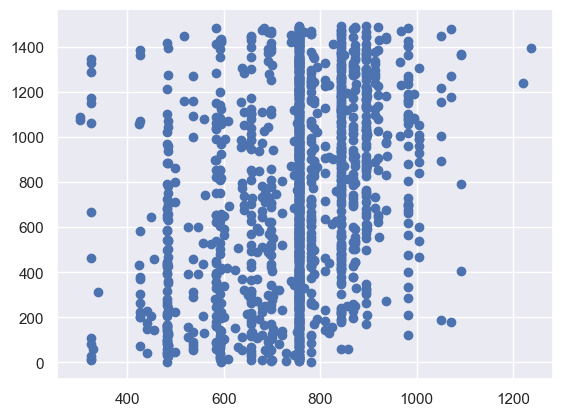

In [55]:
from sklearn.kernel_ridge import KernelRidge
from sklearn_extra.robust import RobustWeightedRegressor
from sklearn_extra.kernel_methods import  EigenProRegressor
#cols_keep = select_columns(X_train_augmented,y_train,size_features=50)
#0.0455
X_train_augmented_t = np.array(X_train_augmented)
X_test_augmented_t = np.array(X_test_augmented)


l1_lasso_model = CustomLinearModel(
    X=np.array(X_train_augmented_t), Y=np.array(y_train), regularization=0.01, alpha= 1.2, optim = 'BFGS'
)

l1_lasso_model = Lasso(alpha=0.01)
#l1_lasso_model = KLIEP(l1_lasso_model, Xt=np.array(X_test_augmented), kernel="rbf", gamma=[0.01], random_state=0)
#l1_lasso_model = EigenProRegressor()#KernelRidge(kernel='rbf', gamma = 0.01, alpha=100)
l1_lasso_model.fit(np.array(X_train_augmented_t), np.array(y_train.rank()))

y_pred = l1_lasso_model.predict(X_train_augmented_t)
print(my_custom_loss_func(y_pred,y_train.rank()))
#print(list(zip(X_train_augmented.columns,l1_lasso_model.coef_)))

plt.scatter(y_pred,y_train.rank())


In [48]:
l1_lasso_model.coef_

array([-0.10266633,  0.05477665, -0.1856443 ,  0.10364629,  0.02498913,
       -0.        , -0.01459099, -0.        ,  0.05315118, -0.        ,
        0.00298861,  0.03233099,  0.        ,  0.00263629, -0.01818863,
       -0.02299166,  0.        ,  0.        ,  0.        , -0.02627982])

In [49]:
l = list(zip(X_train_augmented,l1_lasso_model.coef_))
l

[('DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#FR_FLOW_COAL_4',
  -0.10266632605100906),
 ('DE_NET_EXPORT#DE_FLOW_LIGNITE#CARBON_RET#DE_CONSUMPTION_RENEWABLE_3',
  0.05477664636759234),
 ('DE_HYDRO#FR_WINDPOW#DE_CONSUMPTION_RENEWABLE#GAS_RET_1',
  -0.18564430099006504),
 ('FR_WINDPOW#CARBON_RET#DE_CONSUMPTION_RENEWABLE#COAL_RET_3',
  0.1036462946811222),
 ('DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#DE_FLOW_COAL#COAL_RET#FR_FLOW_COAL_1',
  0.024989129809978312),
 ('DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#DE_FLOW_COAL#GAS_RET#FR_PRODUCTION_3',
  -0.0),
 ('DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#CARBON_RET#GAS_RET#FR_FLOW_COAL_2',
  -0.014590985780612816),
 ('DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2 DE_NET_EXPORT#DE_FLOW_LIGNITE#CARBON_RET#DE_CONSUMPTION_RENEWABLE_3',
  -0.0),
 ('DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2 DE_RESIDUAL_LOAD#DE_FLOW_LIGNITE#FR_FLOW_COAL#DE_NEED_3',
  0.05315118089039479),
 ('DE_NET_E

In [39]:
np.sum(l1_lasso_model.coef_!= 0) 

13

In [50]:

l = list(zip(X_train_augmented.columns,l1_lasso_model.coef_))
z = []
for i in l:
    if(i[1]!=0):
        z.append(i[0])
z


['DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#FR_FLOW_COAL_4',
 'DE_NET_EXPORT#DE_FLOW_LIGNITE#CARBON_RET#DE_CONSUMPTION_RENEWABLE_3',
 'DE_HYDRO#FR_WINDPOW#DE_CONSUMPTION_RENEWABLE#GAS_RET_1',
 'FR_WINDPOW#CARBON_RET#DE_CONSUMPTION_RENEWABLE#COAL_RET_3',
 'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#DE_FLOW_COAL#COAL_RET#FR_FLOW_COAL_1',
 'DE_NET_EXPORT#DE_HYDRO#DE_RESIDUAL_LOAD#COAL_RET_2 FR_WINDPOW#CARBON_RET#GAS_RET#FR_FLOW_COAL_2',
 'DE_NET_EXPORT#DE_HYDRO#DE_FLOW_LIGNITE#COAL_RET_2 DE_RESIDUAL_LOAD#DE_FLOW_LIGNITE#FR_FLOW_COAL#DE_NEED_3',
 'DE_NET_EXPORT#DE_HYDRO#DE_CONSUMPTION_RENEWABLE#COAL_RET_1 DE_NET_EXPORT#COAL_RET#GAS_RET#DE_NEED_4',
 'DE_NET_EXPORT#FR_WINDPOW#GAS_RET#FR_FLOW_COAL_1 DE_FLOW_LIGNITE#CARBON_RET#COAL_RET#GAS_RET_2',
 'DE_NET_EXPORT#DE_FLOW_LIGNITE#GAS_RET#DE_NEED_3 DE_HYDRO#DE_RESIDUAL_LOAD#DE_FLOW_COAL#DE_CONSUMPTION_RENEWABLE_2',
 'DE_HYDRO#DE_RESIDUAL_LOAD#DE_FLOW_COAL#DE_CONSUMPTION_RENEWABLE_2 DE_HYDRO#DE_FLOW_COAL#GAS_RET#DE_NEED_3',
 'DE_

In [41]:
y_predict = l1_lasso_model.predict(X_test_augmented)

In [51]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['TARGET'] = y_predict
sub.to_csv("submissions/best_mape_augmented_3.csv",index=False)

In [52]:
y_best = pd.read_csv("submissions/best_models/best_mape_augmented_3.csv")
test = pd.merge(sub,y_best,on='ID')
test.corr()

,ID,TARGET_x,TARGET_y
ID,1.000000,0.014046,0.073789
TARGET_x,0.014046,1.000000,0.514909
TARGET_y,0.073789,0.514909,1.000000


In [53]:
test.cov()

,ID,TARGET_x,TARGET_y
ID,391499.374770,1.884878,8.488092
TARGET_x,1.884878,0.045998,0.020303
TARGET_y,8.488092,0.020303,0.033799
